![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [1]:
# Importing all modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform


In [2]:
# loading the data
rental = pd.read_csv('rental_info.csv', parse_dates=['rental_date', 'return_date'])

# getting the rental days from the return and rental date
rental['rental_length_days'] = (rental['return_date'] - rental['rental_date']).dt.days

# creating dummy variables for special_features column using np.where
#Remove the curly braces and quotes
spec_f = rental['special_features']
cleaned = spec_f.str.strip('{}').str.replace('"', '', regex=False)

# Split each string by comma
split_lists = cleaned.str.split(',')

# Flatten the list of lists and strip extra whitespace
all_items = [item.strip() for sublist in split_lists for item in sublist]

# Get unique values
unique_items = pd.Series(all_items).unique()

# Looping through the unique items to create dummy variables
for i in unique_items:
    rental[i] = np.where(rental['special_features'].str.contains(i),1,0)

# Ensuring column names follow stndard convention
rental.columns = [col.replace(' ', '_') for col in rental.columns]

# dropping used columns
rental = rental.drop(columns=['rental_date', 'return_date', 'special_features'])

rental.sample(9)

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,Trailers,Behind_the_Scenes,Commentaries,Deleted_Scenes
3816,4.99,2006.0,4.99,109.0,10.99,1,0,0,0,24.9001,11881.0,24.9001,2,0,0,1,0
8104,0.99,2005.0,0.99,87.0,23.99,0,0,0,0,0.9801,7569.0,0.9801,5,1,1,1,0
13905,2.99,2009.0,2.99,115.0,29.99,0,1,0,0,8.9401,13225.0,8.9401,2,0,1,0,0
2002,6.99,2010.0,4.99,167.0,24.99,0,0,1,0,48.8601,27889.0,24.9001,5,0,0,0,1
3797,6.99,2005.0,4.99,179.0,29.99,0,0,0,1,48.8601,32041.0,24.9001,9,1,1,1,0
1434,5.99,2010.0,4.99,162.0,23.99,0,0,1,0,35.8801,26244.0,24.9001,5,0,1,1,1
5067,0.99,2007.0,0.99,129.0,17.99,0,0,0,1,0.9801,16641.0,0.9801,1,1,1,1,0
7198,4.99,2006.0,4.99,180.0,13.99,1,0,0,0,24.9001,32400.0,24.9001,2,0,0,1,0
7361,3.99,2010.0,2.99,137.0,9.99,1,0,0,0,15.9201,18769.0,8.9401,4,0,0,1,1


In [3]:
# setting my features and target variables
X = rental.drop('rental_length_days', axis=1)
y = rental['rental_length_days']

# performing a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# create a pipeline and tune Lasso's alpha to pick the best alpha
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(alphas=np.arange(0.01, 10.5, 0.5), cv=5, random_state=9))
])

pipeline.fit(X_train, y_train)

# getting the best alpha value
best_alpha = pipeline.named_steps['lasso_cv'].alpha_

print("Best alpha:", best_alpha)

Best alpha: 0.01


Selected features: ['amount', 'rental_rate', 'amount_2', 'rental_rate_2']


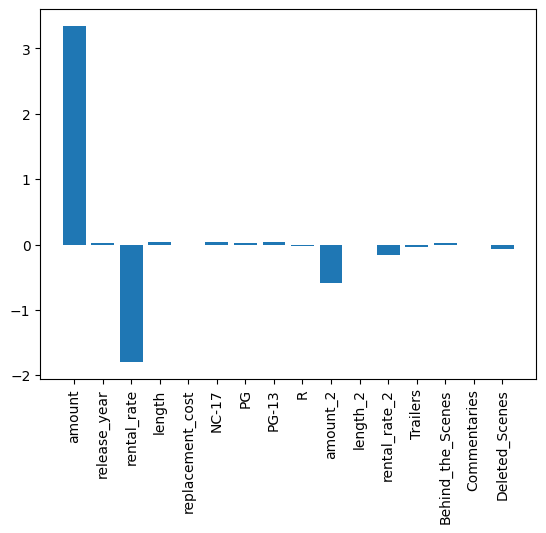

In [4]:
# creating a new pipeline 
new_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=best_alpha))
])

new_pl.fit(X_train, y_train)

# get feature names
feat = X.columns

# Get the Lasso model from the pipeline
lasso = new_pl.named_steps['lasso']

# Selecting features  based on coef and plotting them
selected_features = [name for name, coef in zip(feat, lasso.coef_) if abs(coef) > 0.1]
print("Selected features:", selected_features)

# Assuming rental is a DataFrame
lass = lasso.coef_
plt.bar(feat, lass)
plt.xticks(rotation=90)
plt.show()

In [11]:
# subsetting train and test sets for selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=3, random_state=9),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=9)
}

# Train and evaluate each model
mse_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = MSE(y_test, y_pred)
    mse_results[name] = mse

# Show results
print("Model Performance (MSE Scores):")
for name, score in mse_results.items():
    print(f"{name}: {score:.4f}")

Model Performance (MSE Scores):
Linear Regression: 2.9411
Ridge Regression: 2.9411
Decision Tree: 3.2610
Random Forest: 2.0237


In [12]:
# Tuning the best performing model
model = RandomForestRegressor(random_state=9)
param_dist = {
            "n_estimators": randint(50, 150),
            "max_depth": randint(3, 15),
            "min_samples_split": randint(2, 10),
            "min_samples_leaf": randint(1, 5)
}

# Run RandomizedSearchCV for the model
search = RandomizedSearchCV(
            model, param_distributions=param_dist,
            n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=9, n_jobs=-1)
search.fit(X_train, y_train)

# Print results
print("Best Parameters Found:", search.best_params_)


Best Parameters Found: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 106}


In [16]:
# Training the best model with the best parameters
best_params = search.best_params_
rf_best = {k.replace('model__', ''): v for k, v in best_params.items()}
rf = RandomForestRegressor(**rf_best,random_state=9)
rf.fit(X_train, y_train)
rf_p = rf.predict(X_test)
mse = MSE(y_test, rf_p)

print(f"Model Performance (MSE Score): {mse:.4f}")


Model Performance (MSE Score): 2.0246


In [17]:
# computing the model's accuracy
r2 = r2_score(y_test, rf_p)
accuracy_percent = r2 * 100 
print(f" Accuracy: {accuracy_percent:.2f}%")

 Accuracy: 71.48%
